In [18]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
from utils import effective_sample_size
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib
import pandas as pd
np.random.seed(0)

In [26]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis);

Da fare:
- Mettere in ordine funzioni ESS in utils
- Inserire un controllo che entrambe le medie siano state prodotte
  
Prove per ESS:
- Prova di nuovo con true variance
- Prova prendendo min e non media di n_eff,i
- Prova di nuovo langevin dopo ultima correzione
- Fare tutte queste prove anche con NUTS
- Scrivere a jakobbo

Problemi rimasti:
- MN quante gradient evaluation
- NUTS viene troppo alto il risultato

# MCHMC
## 1 *Leapfrog integrator*
### 1.1 Autotuning

In [20]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fbd0ed48af0> with 200 steps, updating epsilon


Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


Optimal epsilon: 6.395433616638184


In [21]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d,int_scheme=integ.leapfrog, N=N, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fbd0ed48af0> with 200 steps, updating L


Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]

Optimal L: 11.12897777557373


### 1.2 ESS
#### 1.2.1 Strategy 1: $(b_2)^2=2/n_{eff}$ and with n_eff with mean

In [22]:
take_minimum = False #strategy 1

In [27]:
# PRODUCING THE SAMPLES AND COMPUTING ESS
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, pbar=True)
    utils.check_two_modes(Xi, no_print=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi, take_minimum=take_minimum)
    ESS.append(ess)

X = torch.cat(X, dim=0)
two_modes = utils.check_two_modes(X, no_print=True)
if not two_modes: print("mierdas, single mode")



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 96.70it/s]


In [24]:
print('ESS MCHMC-bounces LP integrator n_eff with mean:', np.mean(ESS[ESS != None]))

ESS MCHMC-bounces LP integrator n_eff with mean: 0.05162622612287042


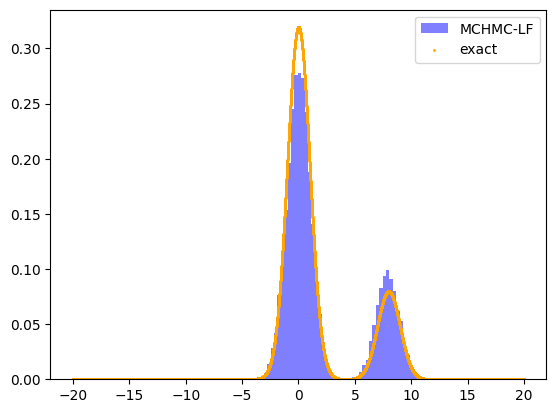

In [25]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

#X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

#### 1.2.2 Strategy 2: $(b_2)^2=2/n_{eff}$ and with n_eff with mean

In [ ]:
# to do

#### 1.2.3 Strategy 3: Using truth variance

In [7]:
# to do

## 1.3 NUTS

In [19]:
# to do

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


------------------------------------------------
-----------------------------------
## 2 *Minimal Norm integrator*:

In [81]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


Optimal epsilon: 14.522591590881348


In [82]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]

Optimal L: 7.627333207701469


In [90]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, int_scheme=integ.minimal_norm, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 74.76it/s]


In [92]:
#print('ESS for bimodal distribution with MCHMC-bounces with MN integrator:', np.mean(ESS))

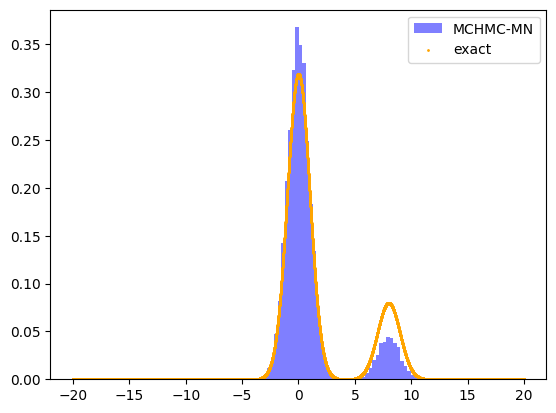

In [93]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [101]:
# get the covariance matrix of the distribution 
d = 100
cov = funct.get_ill_cov(d)

In [95]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=5, fn=funct.ill_cond_gaussian,
                                         algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, 
                                         iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


Optimal epsilon: 1.2750605583190917


In [113]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian,
                      algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

Optimal L: 20.3170042324176


In [103]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, int_scheme=integ.leapfrog, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 176.17it/s]


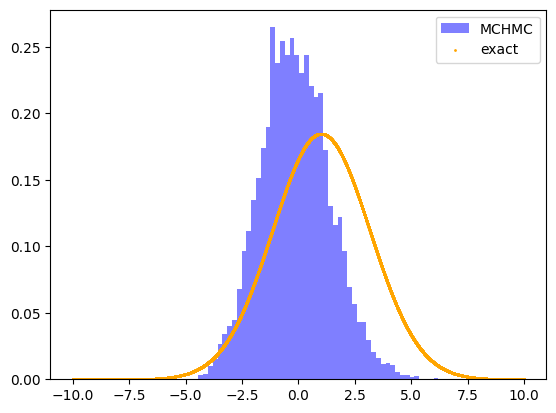

In [109]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 1, cov[0,0]) 

#X = X.detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

- *Minimal Norm integrator*:

In [111]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, 
                                         int_scheme=integ.minimal_norm, iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]

Optimal epsilon: 5.346311807632446


In [114]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian,
                      algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]

Optimal L: 20.087843260654303


In [115]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, int_scheme=integ.minimal_norm, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 127.16it/s]


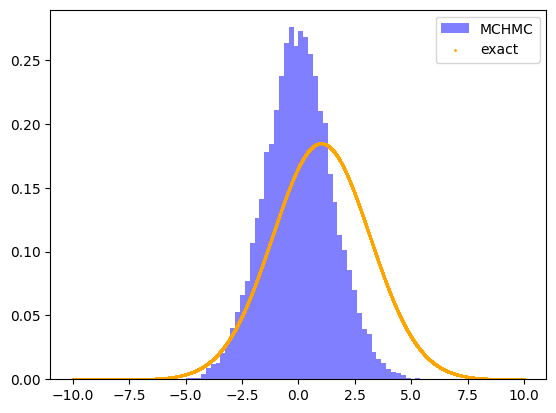

In [116]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 1, cov[0,0]) 

X = X.detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

---------------

### Rosenbrock - Parameters optimization 

- *Leapfrog integrator*:

In [118]:
d = 36
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=np.sqrt(d), fn=funct.rosenbrock,
                                         algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]

Optimal epsilon: 0.1651273250579834


In [119]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.rosenbrock, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]

Optimal L: 4.61011203142389


In [120]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=d, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.rosenbrock, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 210.78it/s]


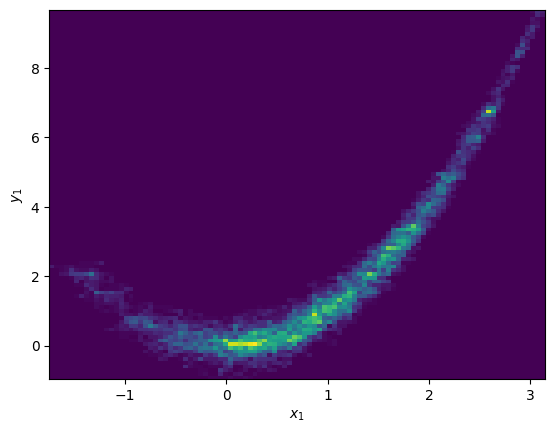

In [121]:
plt.hist2d(X[:, 0], X[:, 1], 100)
plt.xlabel(fr'$x_1$')
plt.ylabel(fr'$y_1$')
plt.show()

- *Minimal Norm integrator*:

---------------

### Neal's funnel - Parameters optimization

- *Leapfrog integrator*:

In [122]:
d = 20
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=np.sqrt(d), fn=funct.neals_funnel,
                                         algorithm=MCHMC.MCHMC_bounces, iterations=5, int_scheme=integ.leapfrog, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]

Optimal epsilon: 0.7082988619804382


In [123]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.neals_funnel, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]

Optimal L: 11.091380052307914


In [124]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=d, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.neals_funnel, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 197.90it/s]


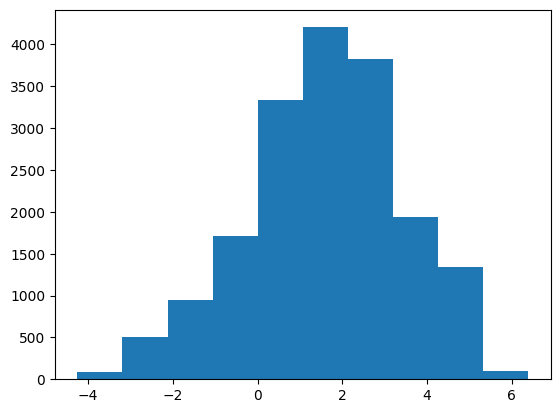

In [125]:
plt.hist(X[:,0])
plt.show()

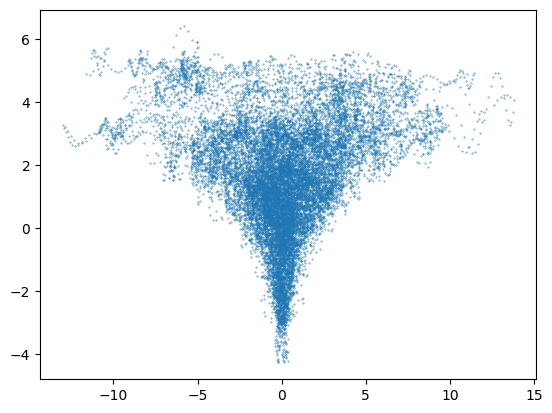

In [127]:
plt.scatter(X[:, 1], X[:, 0], s=0.1)
plt.show()

- *Minimal Norm integrator*: